In [66]:
import sys
sys.path.append("../")

In [67]:
import pandas as pd
import datetime as dt
import plotly.graph_objects as go
from technicals.indicators import RSI
from technicals.patterns import apply_patterns
from plotting import CandlePlot

In [68]:
df_raw = pd.read_pickle("../data/EUR_USD_H1.pkl")

In [69]:
df_raw.shape

(49667, 14)

In [70]:
df_an = df_raw.copy()#df_raw.iloc[-6000:].copy()
df_an.reset_index(drop=True, inplace=True)

In [71]:
df_an.shape

(49667, 14)

In [72]:
df_an = RSI(df_an)

In [73]:
df_an.tail()

,time,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c,RSI_14
49662,2023-12-29 17:00:00+00:00,4230,1.10607,1.10669,1.10529,1.10643,1.10600,1.10661,1.10521,1.10636,1.10614,1.10677,1.10537,1.10650,48.386811
49663,2023-12-29 18:00:00+00:00,5238,1.10641,1.10641,1.10493,1.10532,1.10634,1.10634,1.10485,1.10524,1.10648,1.10648,1.10501,1.10541,44.564009
49664,2023-12-29 19:00:00+00:00,2778,1.10530,1.10540,1.10382,1.10410,1.10522,1.10531,1.10375,1.10402,1.10538,1.10549,1.10389,1.10417,40.753032
49665,2023-12-29 20:00:00+00:00,2265,1.10411,1.10510,1.10384,1.10411,1.10403,1.10502,1.10376,1.10403,1.10419,1.10517,1.10392,1.10419,40.797723
49666,2023-12-29 21:00:00+00:00,1250,1.10410,1.10413,1.10342,1.10374,1.10403,1.10406,1.10333,1.10363,1.10418,1.10420,1.10349,1.10386,39.607275


In [74]:
df_an = apply_patterns(df_an)

In [75]:
df_an['EMA_200'] = df_an.mid_c.ewm(span=200, min_periods=200).mean()

In [76]:
df_an.columns

Index(['time', 'volume', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'bid_o', 'bid_h',
       'bid_l', 'bid_c', 'ask_o', 'ask_h', 'ask_l', 'ask_c', 'RSI_14',
       'body_lower', 'body_upper', 'body_bottom_perc', 'body_top_perc',
       'body_perc', 'direction', 'body_size', 'low_change', 'high_change',
       'body_size_change', 'mid_point', 'mid_point_prev_2', 'body_size_prev',
       'direction_prev', 'direction_prev_2', 'body_perc_prev',
       'body_perc_prev_2', 'HANGING_MAN', 'SHOOTING_STAR', 'SPINNING_TOP',
       'MARUBOZU', 'ENGULFING', 'TWEEZER_TOP', 'TWEEZER_BOTTOM',
       'MORNING_STAR', 'EVENING_STAR', 'EMA_200'],
      dtype='object')

In [77]:
our_cols = ['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c',
                'ask_c','bid_c', 'ENGULFING', 'direction', 'EMA_200', 'RSI_14' ]

In [78]:
df_slim = df_an[our_cols].copy()
df_slim.dropna(inplace=True)
df_slim.reset_index(drop=True, inplace=True)

In [79]:
df_slim.head()

,time,mid_o,mid_h,mid_l,mid_c,ask_c,bid_c,ENGULFING,direction,EMA_200,RSI_14
0,2016-01-19 07:00:00+00:00,1.08736,1.08764,1.08595,1.08652,1.08660,1.08645,False,-1,1.088334,36.239350
1,2016-01-19 08:00:00+00:00,1.08654,1.08846,1.08636,1.08846,1.08861,1.08832,True,1,1.088336,47.615598
2,2016-01-19 09:00:00+00:00,1.08844,1.08890,1.08702,1.08724,1.08749,1.08699,False,-1,1.088323,42.482293
3,2016-01-19 10:00:00+00:00,1.08728,1.08834,1.08662,1.08730,1.08737,1.08722,False,1,1.088312,42.808846
4,2016-01-19 11:00:00+00:00,1.08728,1.08732,1.08599,1.08630,1.08637,1.08623,True,-1,1.088289,38.849941


In [80]:
BUY = 1
SELL = -1
NONE = 0
RSI_LIMIT = 50.0

def apply_signal(row):
    if row.ENGULFING == True:
        if row.direction == BUY and row.mid_l > row.EMA_200:
            if row.RSI_14 > RSI_LIMIT:
                return BUY
        if row.direction == SELL and row.mid_h < row.EMA_200:
            if row.RSI_14 < RSI_LIMIT:
                return SELL
    return NONE        

In [81]:
df_slim["SIGNAL"] = df_slim.apply(apply_signal, axis=1)

In [82]:
df_slim["SIGNAL"].value_counts()

SIGNAL
 0    45070
-1     2207
 1     2191
Name: count, dtype: int64

In [83]:
LOSS_FACTOR = -1.0
PROFIT_FACTOR = 1.5

def apply_take_profit(row):
    if row.SIGNAL != NONE:
        return (row.mid_c - row.mid_o) * 1.5 + row.mid_c
    else:
        return 0.0

def apply_stop_loss(row):
    if row.SIGNAL != NONE:
        return row.mid_o
    else:
        return 0.0

In [84]:
df_slim["TP"] = df_slim.apply(apply_take_profit, axis=1)
df_slim["SL"] = df_slim.apply(apply_stop_loss, axis=1)

In [85]:
df_slim[df_slim.SIGNAL==BUY].head()

,time,mid_o,mid_h,mid_l,mid_c,ask_c,bid_c,ENGULFING,direction,EMA_200,RSI_14,SIGNAL,TP,SL
15,2016-01-19 22:00:00+00:00,1.09060,1.09143,1.09052,1.09140,1.09153,1.09127,True,1,1.088541,57.545307,1,1.092600,1.09060
17,2016-01-20 00:00:00+00:00,1.09112,1.09246,1.09100,1.09214,1.09223,1.09206,True,1,1.088610,59.970073,1,1.093670,1.09112
23,2016-01-20 06:00:00+00:00,1.09491,1.09635,1.09491,1.09546,1.09554,1.09538,True,1,1.088985,68.866726,1,1.096285,1.09491
25,2016-01-20 08:00:00+00:00,1.09398,1.09760,1.09397,1.09625,1.09631,1.09619,True,1,1.089121,67.087323,1,1.099655,1.09398
146,2016-01-27 09:00:00+00:00,1.08673,1.08764,1.08665,1.08726,1.08732,1.08719,True,1,1.085983,60.955020,1,1.088055,1.08673


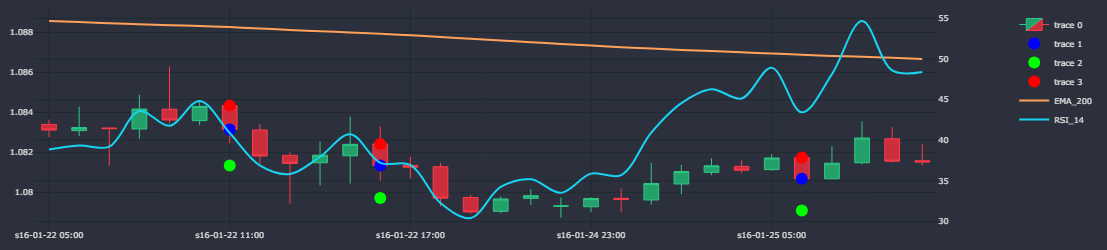

In [86]:
df_plot = df_slim.iloc[70:100]
cp = CandlePlot(df_plot, candles=True)

trades = cp.df_plot[cp.df_plot.SIGNAL != NONE]

markers = ['mid_c', 'TP', 'SL']
marker_colors = ['#0000FF', '#00FF00', '#FF0000']

for i in range(3):
    cp.fig.add_trace(go.Scatter(
        x = trades.sTime,
        y = trades[markers[i]],
        mode = 'markers',
        marker=dict(color=marker_colors[i], size=12)
    ))

cp.show_plot(line_traces=["EMA_200"], sec_traces=['RSI_14'], height=250)

In [87]:
class Trade:
    def __init__(self, row):
        self.running = True
        self.start_index = row.name
        self.start_price = row.mid_c
        self.trigger_price = row.mid_c
        self.SIGNAL = row.SIGNAL
        self.TP = row.TP
        self.SL = row.SL
        self.result = 0.0
        self.end_time = row.time
        self.start_time = row.time
        self.duration = 0
        
    def close_trade(self, row, result, trigger_price):
        self.running = False
        self.result = result
        self.end_time = row.time
        self.trigger_price = trigger_price
        
    def update(self, row):
        self.duration += 1
        if self.SIGNAL == BUY:
            if row.mid_h >= self.TP:
                self.close_trade(row, PROFIT_FACTOR, row.mid_h)
            elif row.mid_l <= self.SL:
                self.close_trade(row, LOSS_FACTOR, row.mid_l)
        if self.SIGNAL == SELL:
            if row.mid_l <= self.TP:
                self.close_trade(row, PROFIT_FACTOR, row.mid_l)
            elif row.mid_h >= self.SL:
                self.close_trade(row, LOSS_FACTOR, row.mid_h)    

In [88]:
open_trades = []
closed_trades = []

for index, row in df_slim.iterrows():
    for ot in open_trades:
        ot.update(row)
        if ot.running == False:
            closed_trades.append(ot)
    open_trades = [x for x in open_trades if x.running == True]
    
    if row.SIGNAL != NONE:
        open_trades.append(Trade(row))    

In [89]:
df_results = pd.DataFrame.from_dict([vars(x) for x in closed_trades])

In [90]:
df_results.result.sum()

367.0

In [91]:
df_results.sort_values(by="start_index", inplace=True)

In [92]:
df_m5 = pd.read_pickle("../data/EUR_USD_M5.pkl")

In [93]:
df_m5.shape

(594303, 14)

In [94]:
df_m5.time.max()

Timestamp('2023-12-29 21:55:00+0000', tz='tzutc()')

In [95]:
df_raw.time.max()

Timestamp('2023-12-29 21:00:00+0000', tz='tzutc()')

In [96]:
from dateutil import parser

In [97]:
time_min = parser.parse("2021-12-15T10:00:00Z")
time_max = parser.parse("2021-12-15T11:00:00Z")
df_m5_s = df_m5[(df_m5.time>=time_min)&(df_m5.time<=time_max)]
df_raw_s = df_raw[(df_raw.time>=time_min)&(df_raw.time<=time_max)]

In [98]:
df_m5_s

,time,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c
441719,2021-12-15 10:00:00+00:00,208,1.12716,1.12745,1.12709,1.12734,1.12708,1.12738,1.12702,1.12727,1.12723,1.12752,1.12715,1.12742
441720,2021-12-15 10:05:00+00:00,132,1.12733,1.12754,1.12726,1.12746,1.12726,1.12747,1.12719,1.12739,1.12740,1.12760,1.12733,1.12752
441721,2021-12-15 10:10:00+00:00,166,1.12744,1.12752,1.12732,1.12746,1.12737,1.12745,1.12725,1.12739,1.12750,1.12760,1.12739,1.12753
441722,2021-12-15 10:15:00+00:00,138,1.12744,1.12770,1.12740,1.12761,1.12737,1.12763,1.12733,1.12754,1.12752,1.12776,1.12747,1.12768
441723,2021-12-15 10:20:00+00:00,252,1.12760,1.12762,1.12712,1.12712,1.12753,1.12756,1.12705,1.12705,1.12767,1.12769,1.12719,1.12719
441724,2021-12-15 10:25:00+00:00,198,1.12711,1.12726,1.12695,1.12695,1.12704,1.12719,1.12688,1.12688,1.12718,1.12733,1.12702,1.12702
441725,2021-12-15 10:30:00+00:00,142,1.12696,1.12698,1.12680,1.12696,1.12689,1.12691,1.12674,1.12690,1.12703,1.12706,1.12686,1.12703
441726,2021-12-15 10:35:00+00:00,121,1.12698,1.12712,1.12698,1.12700,1.12691,1.12705,1.12691,1.12693,1.12704,1.12718,1.12704,1.12706
441727,2021-12-15 10:40:00+00:00,206,1.12698,1.12707,1.12651,1.12656,1.12692,1.12700,1.12644,1.12649,1.12705,1.12714,1.12658,1.12663
441728,2021-12-15 10:45:00+00:00,165,1.12655,1.12668,1.12645,1.12654,1.12648,1.12661,1.12638,1.12648,1.12662,1.12675,1.12652,1.12661


In [99]:
df_raw_s

,time,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c
36941,2021-12-15 10:00:00+00:00,2038,1.12716,1.1277,1.12634,1.12673,1.12708,1.12763,1.12627,1.12666,1.12723,1.12776,1.12640,1.12680
36942,2021-12-15 11:00:00+00:00,2138,1.12674,1.1270,1.12626,1.12698,1.12667,1.12693,1.12619,1.12691,1.12681,1.12706,1.12631,1.12705


In [100]:
df_m5_slim = df_m5[['time','mid_h', 'mid_l' ]].copy()

In [101]:
df_m5_slim.head()

,time,mid_h,mid_l
0,2016-01-07 00:00:00+00:00,1.07811,1.07759
1,2016-01-07 00:05:00+00:00,1.07818,1.07764
2,2016-01-07 00:10:00+00:00,1.07832,1.07812
3,2016-01-07 00:15:00+00:00,1.07830,1.07798
4,2016-01-07 00:20:00+00:00,1.07799,1.07776


In [102]:
df_signals = df_slim[df_slim.SIGNAL != NONE].copy() 

In [103]:
df_signals['m5_start'] = [x + dt.timedelta(hours=1) for x in df_signals.time]

In [104]:
df_signals['start_index_h1'] = df_signals.index

In [105]:
df_signals.head()

,time,mid_o,mid_h,mid_l,mid_c,ask_c,bid_c,ENGULFING,direction,EMA_200,RSI_14,SIGNAL,TP,SL,m5_start,start_index_h1
4,2016-01-19 11:00:00+00:00,1.08728,1.08732,1.08599,1.08630,1.08637,1.08623,True,-1,1.088289,38.849941,-1,1.084830,1.08728,2016-01-19 12:00:00+00:00,4
15,2016-01-19 22:00:00+00:00,1.09060,1.09143,1.09052,1.09140,1.09153,1.09127,True,1,1.088541,57.545307,1,1.092600,1.09060,2016-01-19 23:00:00+00:00,15
17,2016-01-20 00:00:00+00:00,1.09112,1.09246,1.09100,1.09214,1.09223,1.09206,True,1,1.088610,59.970073,1,1.093670,1.09112,2016-01-20 01:00:00+00:00,17
23,2016-01-20 06:00:00+00:00,1.09491,1.09635,1.09491,1.09546,1.09554,1.09538,True,1,1.088985,68.866726,1,1.096285,1.09491,2016-01-20 07:00:00+00:00,23
25,2016-01-20 08:00:00+00:00,1.09398,1.09760,1.09397,1.09625,1.09631,1.09619,True,1,1.089121,67.087323,1,1.099655,1.09398,2016-01-20 09:00:00+00:00,25


In [106]:
df_signals.columns

Index(['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'ask_c', 'bid_c',
       'ENGULFING', 'direction', 'EMA_200', 'RSI_14', 'SIGNAL', 'TP', 'SL',
       'm5_start', 'start_index_h1'],
      dtype='object')

In [107]:
df_signals.drop(['time', 'mid_o', 'mid_h', 'mid_l', 'ask_c', 'bid_c',
                'ENGULFING', 'EMA_200', 'RSI_14', 'direction'], axis=1, inplace=True)

In [108]:
df_signals.head()

,mid_c,SIGNAL,TP,SL,m5_start,start_index_h1
4,1.08630,-1,1.084830,1.08728,2016-01-19 12:00:00+00:00,4
15,1.09140,1,1.092600,1.09060,2016-01-19 23:00:00+00:00,15
17,1.09214,1,1.093670,1.09112,2016-01-20 01:00:00+00:00,17
23,1.09546,1,1.096285,1.09491,2016-01-20 07:00:00+00:00,23
25,1.09625,1,1.099655,1.09398,2016-01-20 09:00:00+00:00,25


In [109]:
df_signals.rename(columns={
    'mid_c' : 'start_price',
    'm5_start' : 'time'
}, inplace=True)

In [110]:
df_signals.head(2)

,start_price,SIGNAL,TP,SL,time,start_index_h1
4,1.0863,-1,1.08483,1.08728,2016-01-19 12:00:00+00:00,4
15,1.0914,1,1.09260,1.09060,2016-01-19 23:00:00+00:00,15


In [111]:
df_m5_slim.head(2)

,time,mid_h,mid_l
0,2016-01-07 00:00:00+00:00,1.07811,1.07759
1,2016-01-07 00:05:00+00:00,1.07818,1.07764


In [113]:
merged = pd.merge(left=df_m5_slim, right=df_signals, on='time', how='left')

In [114]:
merged.fillna(0, inplace=True)

In [115]:
merged.SIGNAL = merged.SIGNAL.astype(int)
merged.start_index_h1 = merged.start_index_h1.astype(int)

In [117]:
merged.head()

,time,mid_h,mid_l,start_price,SIGNAL,TP,SL,start_index_h1
0,2016-01-07 00:00:00+00:00,1.07811,1.07759,0.0,0,0.0,0.0,0
1,2016-01-07 00:05:00+00:00,1.07818,1.07764,0.0,0,0.0,0.0,0
2,2016-01-07 00:10:00+00:00,1.07832,1.07812,0.0,0,0.0,0.0,0
3,2016-01-07 00:15:00+00:00,1.07830,1.07798,0.0,0,0.0,0.0,0
4,2016-01-07 00:20:00+00:00,1.07799,1.07776,0.0,0,0.0,0.0,0


In [118]:
class TradeM5:
    def __init__(self, row):
        self.running = True
        self.start_index_m5 = row.name
        self.start_index_h1 = row.start_index_h1
        self.start_price = row.start_price
        self.trigger_price = row.start_price
        self.SIGNAL = row.SIGNAL
        self.TP = row.TP
        self.SL = row.SL
        self.result = 0.0
        self.end_time = row.time
        self.start_time = row.time
        self.duration = 1
        
    def close_trade(self, row, result, trigger_price):
        self.running = False
        self.result = result
        self.end_time = row.time
        self.trigger_price = trigger_price
        
    def update(self, row):
        self.duration += 1
        if self.SIGNAL == BUY:
            if row.mid_h >= self.TP:
                self.close_trade(row, PROFIT_FACTOR, row.mid_h)
            elif row.mid_l <= self.SL:
                self.close_trade(row, LOSS_FACTOR, row.mid_l)
        if self.SIGNAL == SELL:
            if row.mid_l <= self.TP:
                self.close_trade(row, PROFIT_FACTOR, row.mid_l)
            elif row.mid_h >= self.SL:
                self.close_trade(row, LOSS_FACTOR, row.mid_h)   

In [119]:
open_trades_m5 = []
closed_trades_m5 = []

for index, row in merged.iterrows():
    for ot in open_trades_m5:
        ot.update(row)
        if ot.running == False:
            closed_trades_m5.append(ot)
    open_trades_m5 = [x for x in open_trades_m5 if x.running == True]
    
    if row.SIGNAL != NONE:
        open_trades_m5.append(TradeM5(row))   

In [120]:
df_res_m5 = pd.DataFrame.from_dict([vars(x) for x in closed_trades_m5])

In [121]:
df_res_m5.head()

,running,start_index_m5,start_index_h1,start_price,trigger_price,SIGNAL,TP,SL,result,end_time,start_time,duration
0,False,2445,4,1.08630,1.08740,-1,1.084830,1.08728,-1.0,2016-01-19 12:05:00+00:00,2016-01-19 12:00:00+00:00,2
1,False,2577,15,1.09140,1.09056,1,1.092600,1.09060,-1.0,2016-01-19 23:20:00+00:00,2016-01-19 23:00:00+00:00,5
2,False,2601,17,1.09214,1.09412,1,1.093670,1.09112,1.5,2016-01-20 03:00:00+00:00,2016-01-20 01:00:00+00:00,25
3,False,2673,23,1.09546,1.09469,1,1.096285,1.09491,-1.0,2016-01-20 07:30:00+00:00,2016-01-20 07:00:00+00:00,7
4,False,2697,25,1.09625,1.09370,1,1.099655,1.09398,-1.0,2016-01-20 09:20:00+00:00,2016-01-20 09:00:00+00:00,5


In [122]:
df_res_m5.result.sum()

-86.5